# Lens Modeling for DESIJ0132-1600

##### Author(s): **Fahim Rajit Hossain**, Anik Biswas, S M Rafee Adnan,

### Importing libraries

In [ ]:
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

!pip install emcee
!pip install corner
!pip install cobaya
!pip install lenstronomy
!pip install ruff



%matplotlib inline

drive.mount("/content/drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.0/440.0 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.0/826.0 kB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
  Created wheel for cobaya: filename=cobaya-3.4.1-py3-none-any.whl size=494007 sha256=03a160785108b39eb1a41a3338df8d0ff8a8024ec320ed9ca7942e24091deebf
  Stored in directory: /root/.cache/pip/wheels/0c/83/0d/58fe2b1a72c380a15748f87392e1d40b199acb79d0d7b570bc
  Created wheel for GetDist: filename=getdist-1.4.6-py3-none

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 76.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


Mounted at /content/drive


## Loading Data from h5 Files

In [ ]:
with h5py.File("DESIJ0132-1600_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]


# load HDF5 psf file using h5py
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"


kwargs_data

{'background_rms': 0.015737876438598787,
 'dec_at_xy_0': -7.239999999999993,
 'exposure_time': array([[495.25476, 403.6011 , 453.53333, ..., 472.42017, 412.46506,
         489.70682],
        [412.80304, 515.1279 , 476.61252, ..., 476.53165, 445.4861 ,
         535.7192 ],
        [482.8193 , 496.1837 , 400.38693, ..., 357.60785, 298.3937 ,
         396.26035],
        ...,
        [441.2676 , 450.2588 , 376.2917 , ..., 236.26028, 390.93497,
         169.68163],
        [616.7411 , 419.57428, 460.05017, ..., 258.5865 , 227.25743,
         498.26813],
        [421.1636 , 456.823  , 494.05148, ..., 491.05872, 234.55467,
         349.67188]], dtype=float32),
 'image_data': array([[ 0.00430852,  0.00739825,  0.01483097, ...,  0.61809156,
          0.73717307,  1.03075923],
        [ 0.00502319, -0.03017073, -0.00753662, ...,  0.57677819,
          0.67688715,  0.79889763],
        [ 0.01126465,  0.0042542 ,  0.00804784, ...,  0.50703695,
          0.57667449,  0.61907252],
        ...,
   

<ipython-input-3-f44519a307c8>:8: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
<ipython-input-3-f44519a307c8>:11: RuntimeWarning: invalid value encountered in log10
  axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")


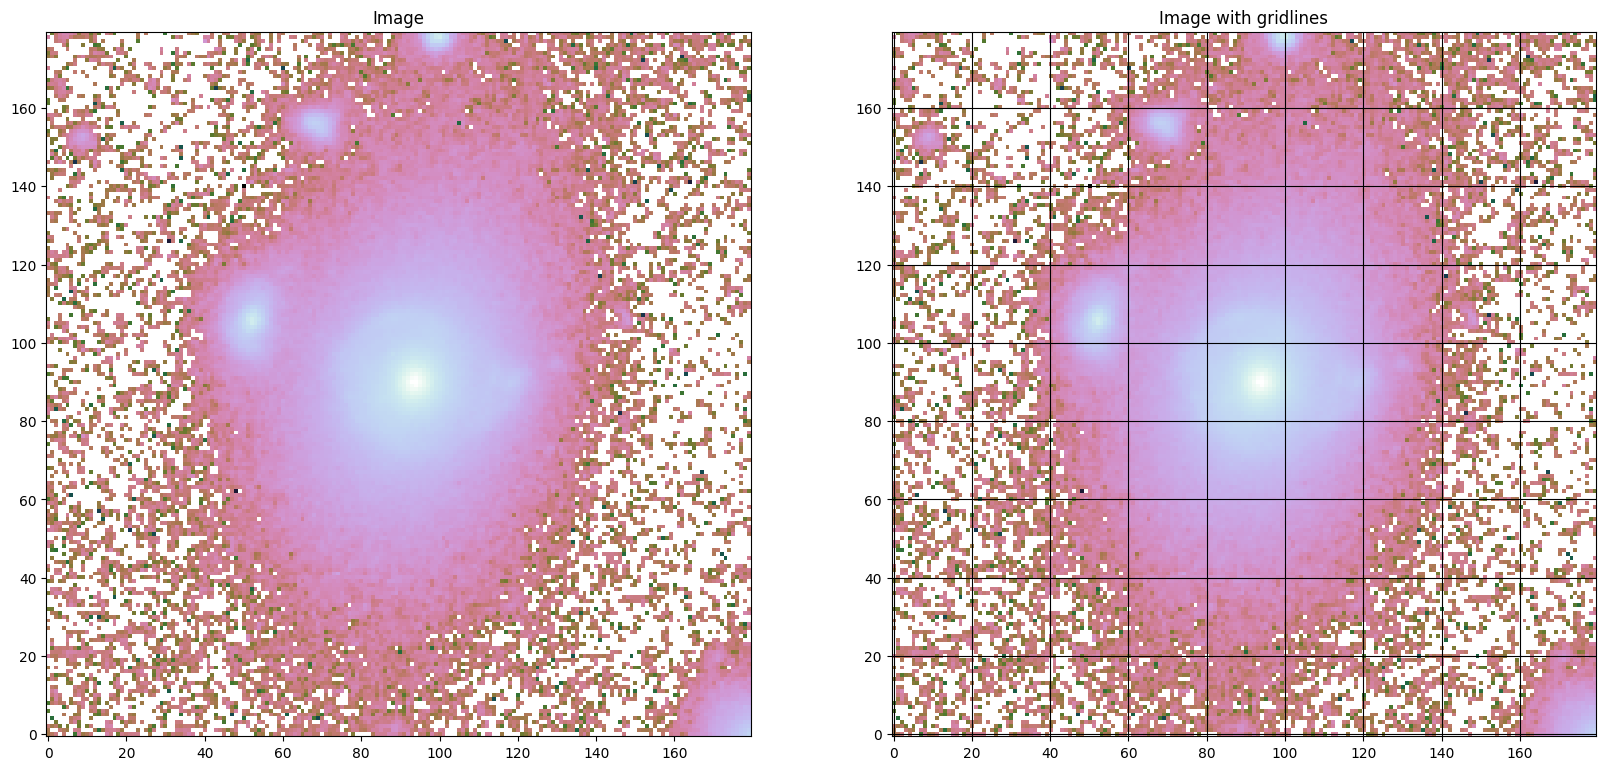

In [ ]:
# extracting image_data from kwargs_data

image = kwargs_data["image_data"]

# Make the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].set_title("Image")

axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[1].set_title("Image with gridlines")
axes[1].grid(True, color="black")

# Show the plots
plt.show()

## Creating Mask

In [ ]:
# coordinate setup

ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

# Mask setup

r = 7.1  # arcsecond
# b = 4
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3,
    lens_center_dec + 1.2,
    1.1,
    1.7,
    np.pi / 10,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.8,
    lens_center_dec + 5.1,
    0.7,
    0.7,
    0,
)
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.7,
    lens_center_dec + 6.7,
    0.7,
    0.7,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.2,
    lens_center_dec + 0.23,
    0.3,
    0.3,
    0,
)

mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.4,
    lens_center_dec - 0.1,
    0.25,
    0.25,
    0,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
    * (1 - mask_ext_5)
)
mask[mask >= 1] = 1
mask[mask < 0] = 0

mask_img_1 = mask.reshape(num_pix, num_pix)

### Setting the subplots


<ipython-input-5-4d2b903b9439>:3: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
<ipython-input-5-4d2b903b9439>:13: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image * mask)
<ipython-input-5-4d2b903b9439>:13: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image * mask)


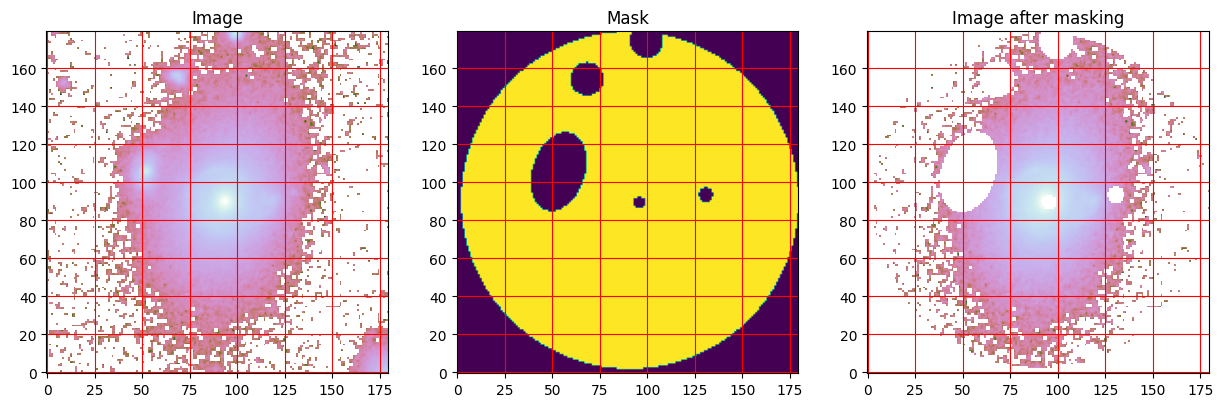

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="red")
axes[0].set_title("Image")

mask = mask.reshape(num_pix, num_pix)

axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="red")
axes[1].set_title("Mask")

image_after_mask = np.log10(image * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="red")
axes[2].set_title("Image after masking")
# Show the plots
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. We checked [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

## Lens Modeling with Lenstronomy

In [ ]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens Galaxy's Mass Model

### EPL Parameters

In [ ]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


fixed_lens.append({"gamma": 2})
kwargs_lens_init.append(
    {
        "theta_E": 1.4,
        "gamma": 2,
        "e1": -0.0749,
        "e2": -0.12077,
        "center_x": -0.2102,
        "center_y": -0.0083,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 1,
        "gamma": 1.7,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 2.1,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

### SHEAR profile Parameters

In [ ]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})


kwargs_lens_init.append({"gamma1": 0.066, "gamma2": -0.00263})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

## Source Galaxy's Light Model

### Sersic Ellipse Parameters

In [ ]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.002,
        "n_sersic": 1,
        "e1": 0.9960,
        "e2": -0.1501,
        "center_x": -0.5247,
        "center_y": -0.0455,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.001,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 1,
        "e2": 1,
        "R_sersic": 0.2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### Shapelets Profile Parameters

In [ ]:
fixed_source.append({"n_max": 10})

kwargs_source_init.append({"center_x": -0.5522, "center_y": 0.045511, "beta": 0.07})
kwargs_source_sigma.append({"center_x": 0.2, "center_y": 0.2, "beta": 0.001})
kwargs_lower_source.append({"center_x": -10, "center_y": -10, "beta": 0.001})
kwargs_upper_source.append({"center_x": 10, "center_y": 10, "beta": 0.1})

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

## Lens Galaxy's Light Model

### 1st Sersic Ellipse Parameters

In [ ]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 1.8705,
        "n_sersic": 2,
        "e1": -0.1897,
        "e2": -0.115,
        "center_x": -0.255,
        "center_y": -0.0594,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### 2nd Sersic Ellipse Parameters

In [ ]:
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5280,
        "n_sersic": 2,
        "e1": -0.0355,
        "e2": -0.0266,
        "center_x": -0.2554,
        "center_y": -0.059,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]
# ,"e1", "e2"

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Combining all the above specification in the `kwargs_params` dictionary

In [ ]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
}

### Numerical settings

In [ ]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band
    # has independent solutions of the
    # surface brightness, 'joint-linear':
    # there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## The Model Fitting

In [ ]:
# using Particle Swarm Optimization

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}]
]

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
]

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list

kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
output = [
    kwargs_result,
    multi_band_list_out,
    fit_output,
    kwargs_fixed_out,
]

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.8176423928618277 reduced X^2 of best position
-9498.551677875852 log likelihood
23234 effective number of data points
[{'theta_E': 1.3996970750354234, 'gamma': 2, 'e1': -0.09276902553348466, 'e2': -0.13040146274483744, 'center_x': -0.19490807604131655, 'center_y': -0.030479443833097728}, {'gamma1': 0.057951424725340095, 'gamma2': -0.00560052273750782, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.0031514938488777645, 'n_sersic': 1.0, 'e1': 0.9675261457715572, 'e2': -0.16720427288749926, 'center_x': -0.48992966561225065, 'center_y': 0.01840366767547679}, {'amp': 1, 'n_max': 10, 'beta': 0.09998238043616739, 'center_x': -0.48992966561225065, 'center_y': 0.01840366767547679}] source result
[{'amp': 1, 'R_sersic': 1.9082223651423162, 'n_sersic': 1.0, 'e1': -0.19830796041993198, 'e2': -0.11700128808635486, 'center_x': -0.2703539620705419, 'center_y': -0.059481218766267836}, {'amp': 1, 'R_

In [ ]:
output_path = "./DESIJ0132-1600_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the Fitted Model

-0.8144873673362932 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8144873673362932


<ipython-input-35-8b2e6c634728>:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


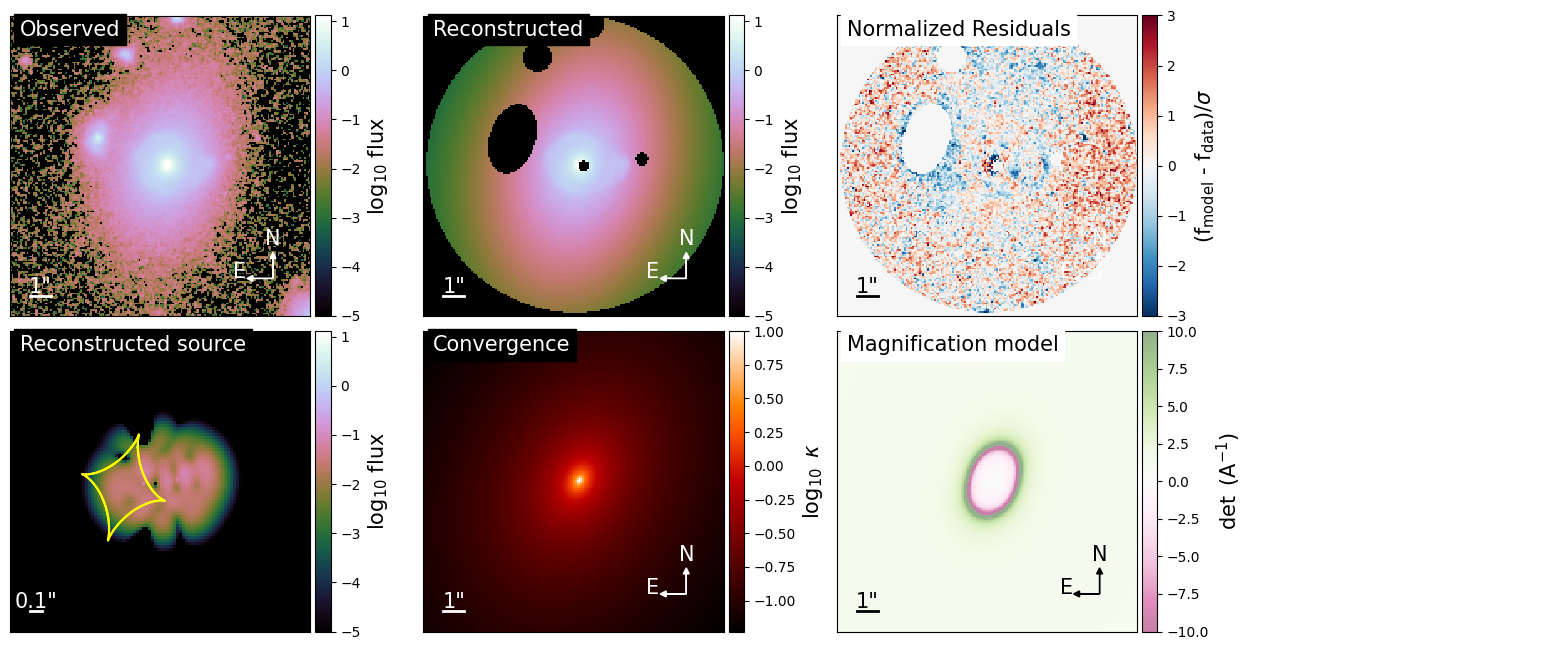

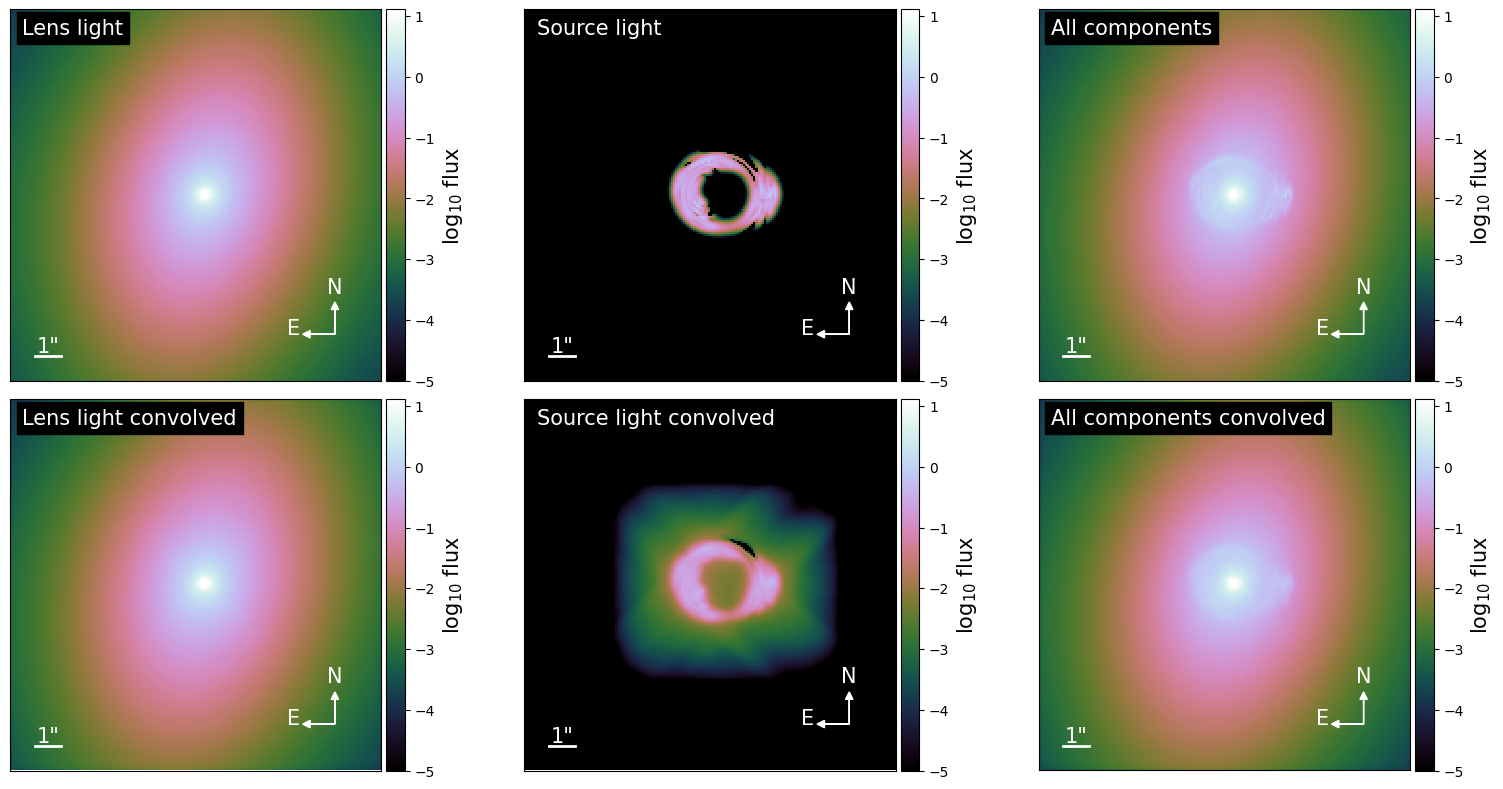

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.025, numPix=100, with_caustics=True
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

## *running MCMC*

In [37]:
# Define the path to the file on Google Drive
mcmc1_backend = "/content/drive/MyDrive/BDLensing/mcmc1_backend.h5"


fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 200,
            "n_walkers": 80,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc1_backend,
            "start_from_backend": True,
        },
    ]
]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()

100%|██████████| 200/200 [1:34:22<00:00, 28.31s/it]

Computing the MCMC...
Number of walkers =  80
Burn-in iterations:  0
Sampling iterations (in current run): 200
5663.099444627762 time taken for MCMC sampling


In [38]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

    # Alternatively, you can access the last chain directly

    last_chain = chain_list_mcmc[-1]
    last_samples = last_chain[1]
    last_param_names = last_chain[2]
    print("Last Chain:")
    print("Sampler type:", last_chain[0])
    print("Parameter names:", last_param_names)
    print("Shape of samples:", last_samples.shape)
else:
    print("No MCMC chains available.")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Shape of samples: (184000, 21)

Last Chain:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Shape of samples: (184000, 21)


## Visualizing the MCMC chain

<ipython-input-39-1eb80459d539>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 2300, N_walkers: 80, N_params: 21
theta_E_lens0 1.3677 ± 0.0071
e1_lens0 -0.0264 ± 0.0172
e2_lens0 -0.1099 ± 0.0152
center_x_lens0 -0.2033 ± 0.0063
center_y_lens0 0.0041 ± 0.0081
gamma1_lens1 0.0993 ± 0.0087
gamma2_lens1 0.0091 ± 0.0068
R_sersic_source_light0 0.0170 ± 0.0061
e1_source_light0 0.9235 ± 0.1018
e2_source_light0 -0.3378 ± 0.1145
center_x_source_light0 -0.4742 ± 0.0112
center_y_source_light0 -0.0440 ± 0.0108
beta_source_light1 0.0996 ± 0.0005
R_sersic_lens_light0 1.9101 ± 0.0074
e1_lens_light0 -0.1931 ± 0.0026
e2_lens_light0 -0.1174 ± 0.0017
center_x_lens_light0 -0.2730 ± 0.0009
center_y_lens_light0 -0.0550 ± 0.0008
R_sersic_lens_light1 0.3749 ± 0.0057
e1_lens_light1 -0.0266 ± 0.0028
e2_lens_light1 -0.0228 ± 0.0024


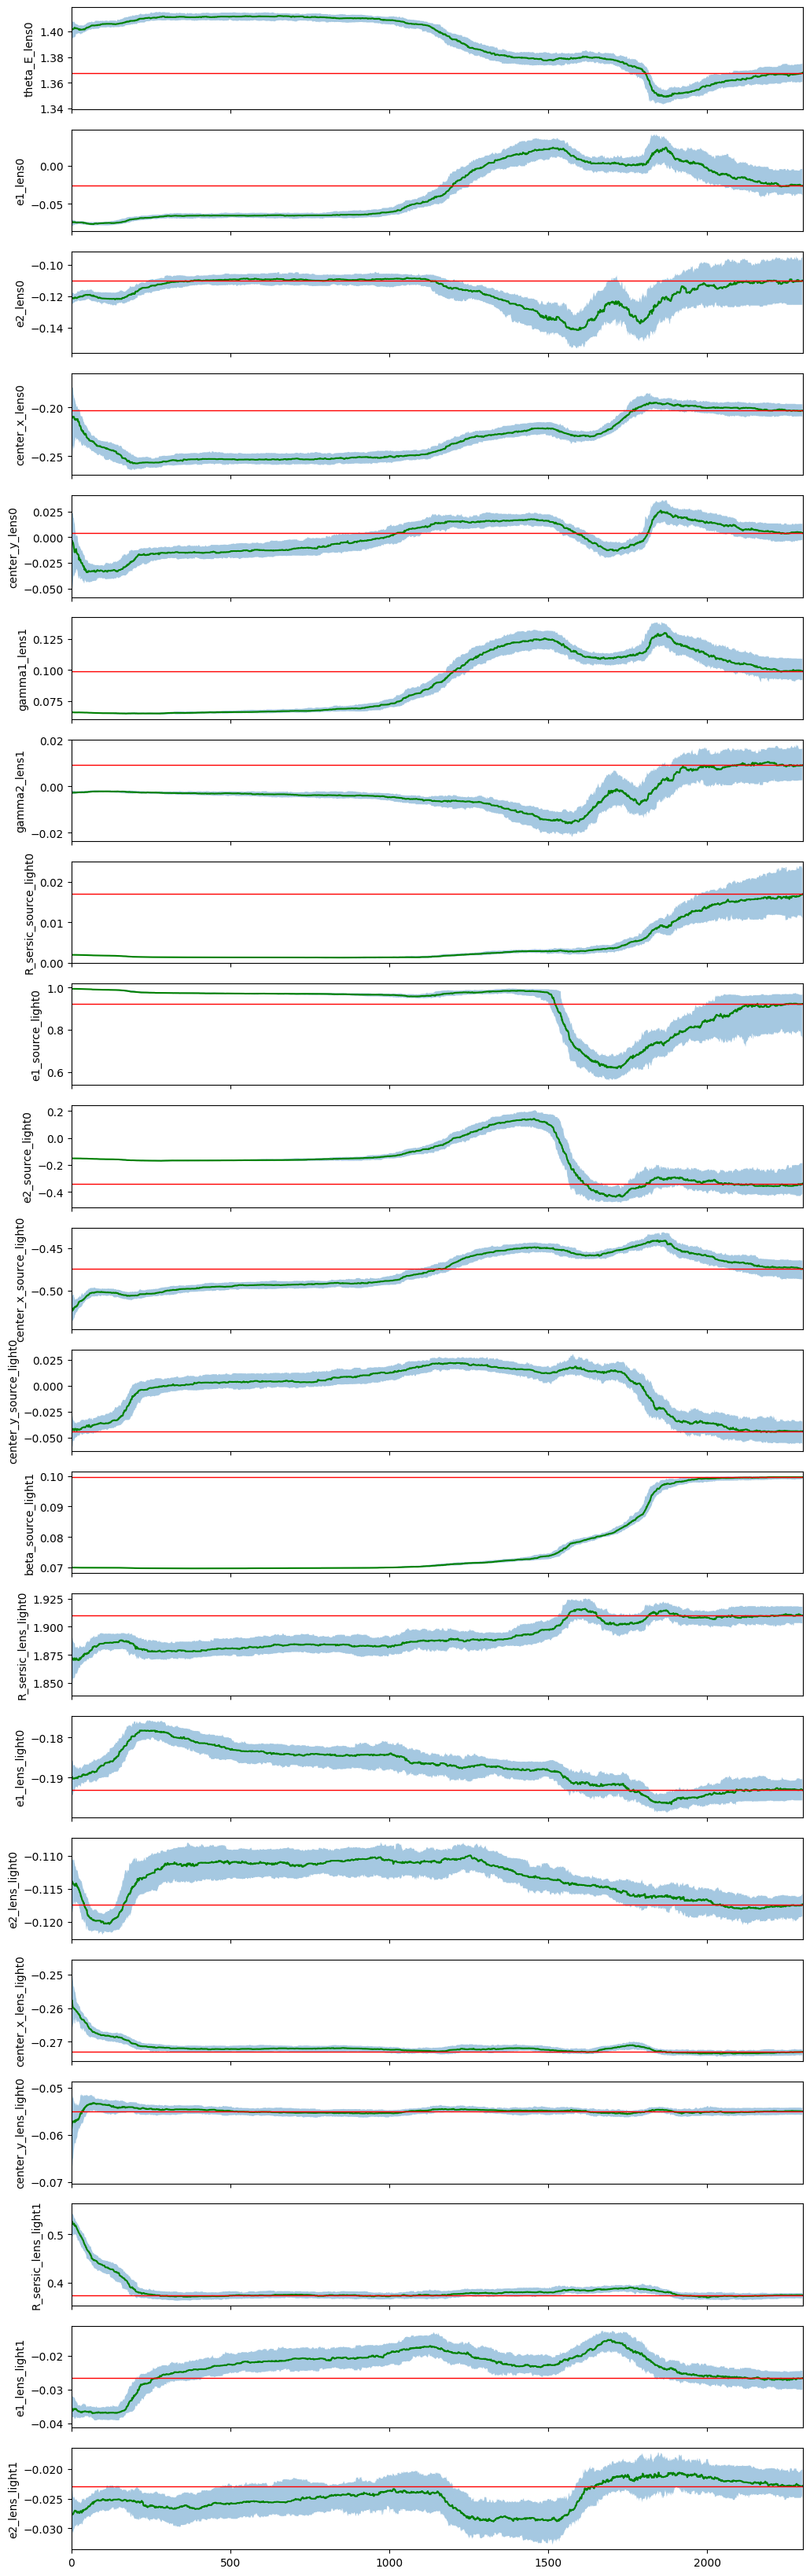

In [39]:
# Traceplot

samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 80  # Adjust the walker ratio as needed
    n_step = 2300  #

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

## Corner Plot

Number of non-linear parameters in the MCMC process: 21
Parameters in order: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'e1_lens_light1', 'e2_lens_light1']
Number of evaluations in the MCMC process: 184000
184000
Shape of samples_mcmc_cut: (1200, 21)


<ipython-input-40-ae17c19136ad>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


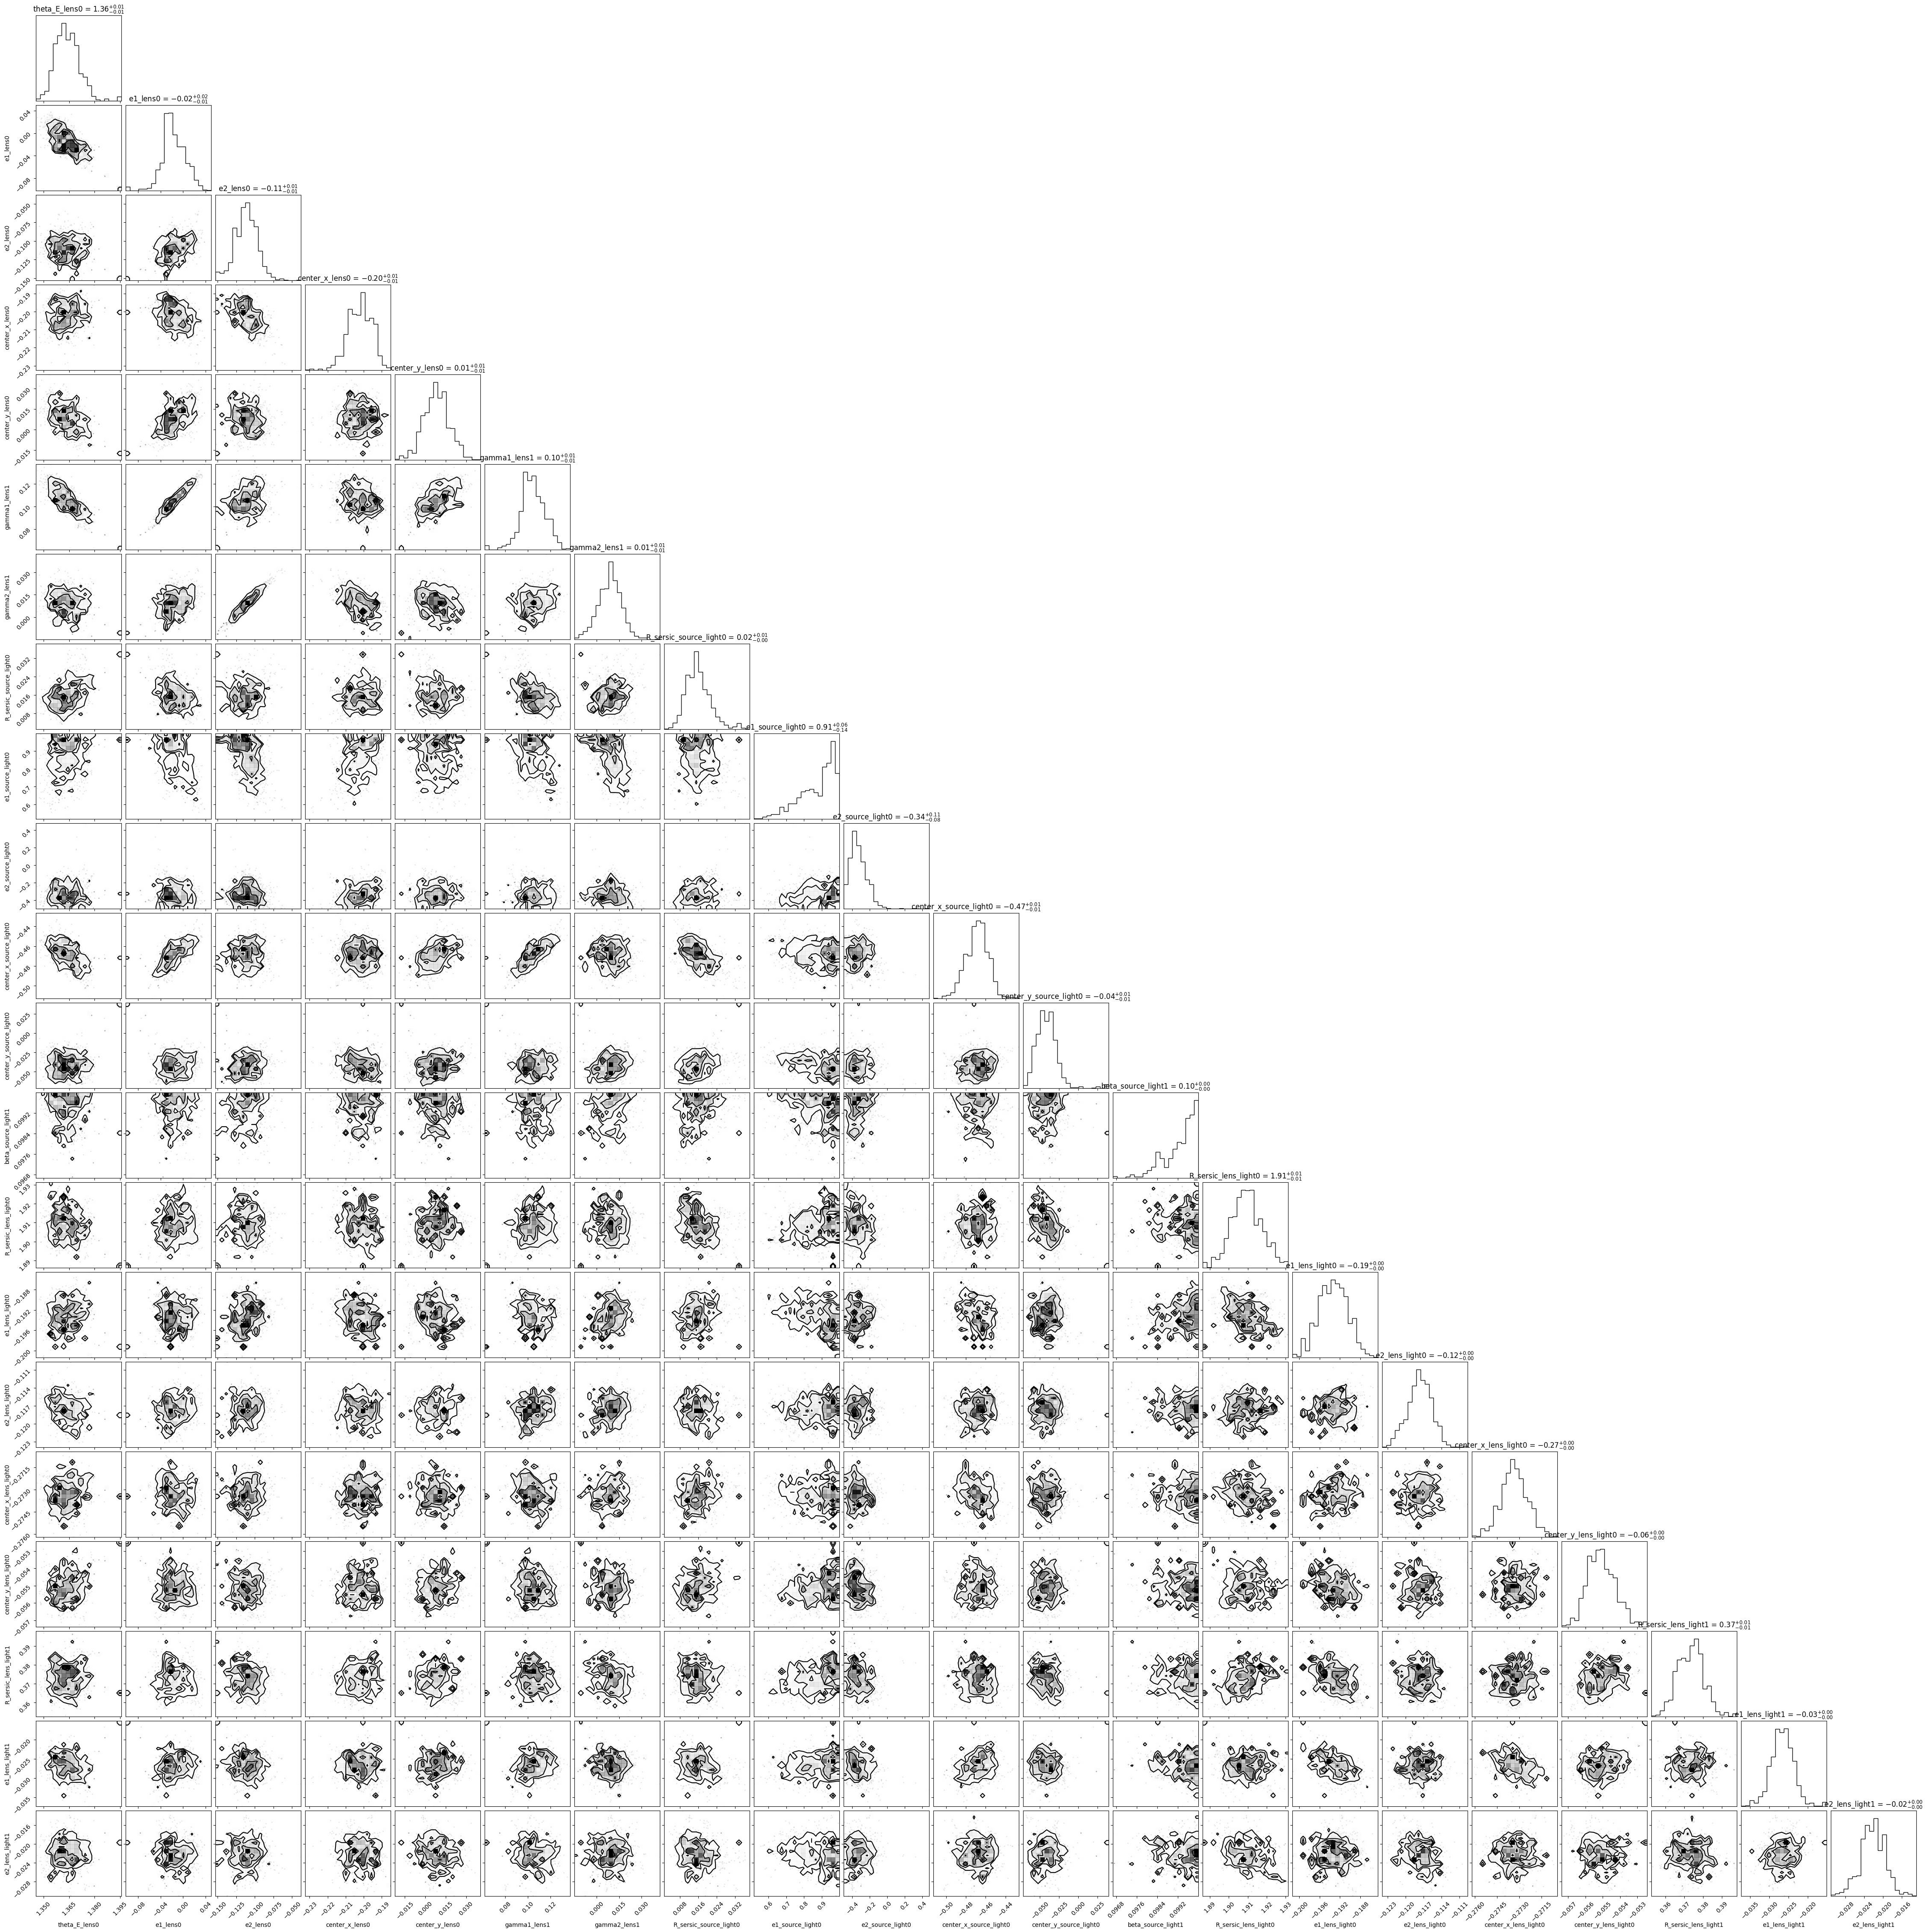

In [40]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 2000
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## Visualizing the fitted model with `MCMC`

-0.8051038665380983 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8051038665380982


<ipython-input-41-58863f6eef99>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


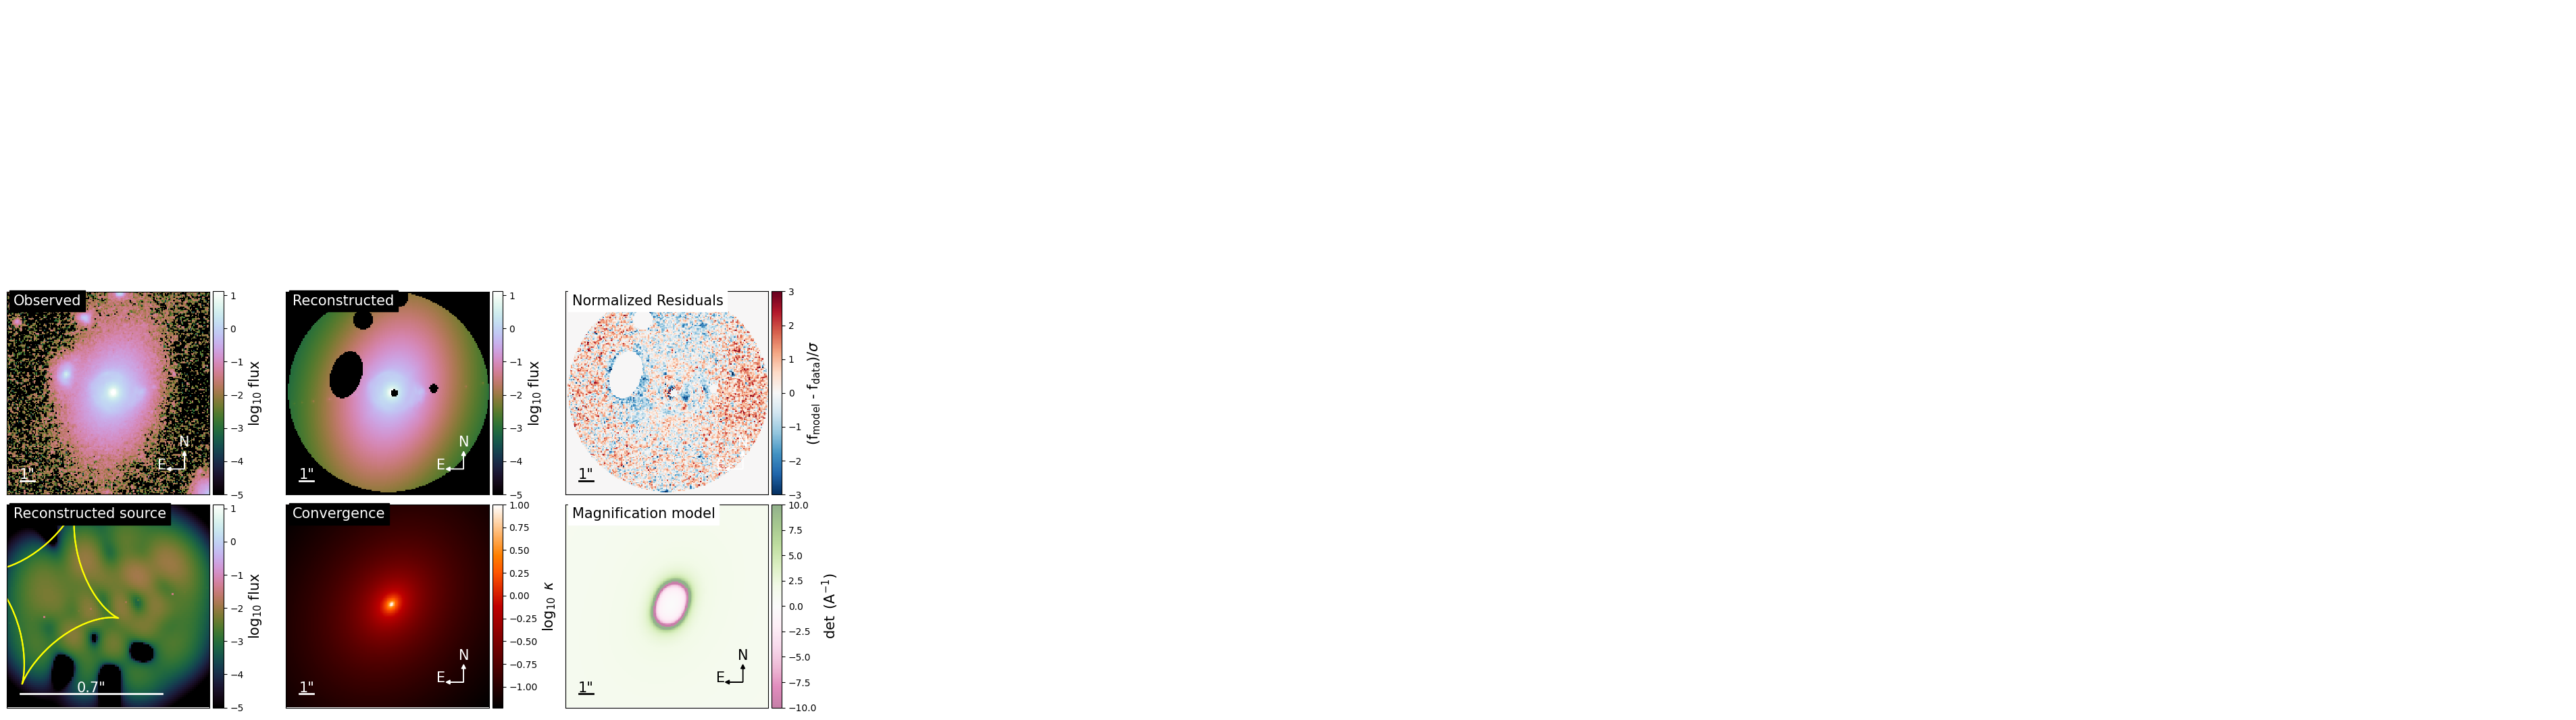

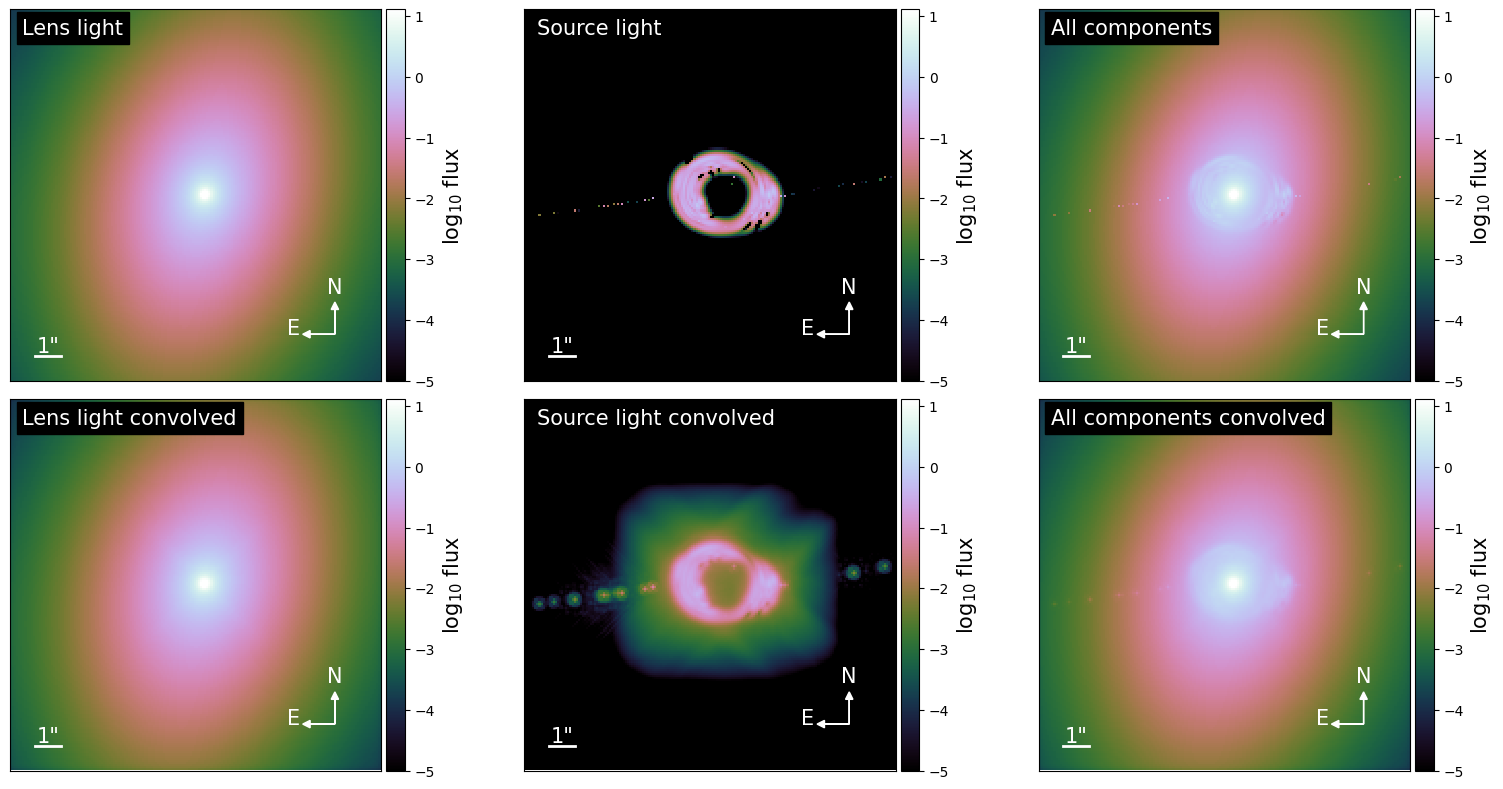

{'kwargs_lens': [{'theta_E': 1.366614121371855, 'gamma': 2, 'e1': -0.034203300371419595, 'e2': -0.11673744593288797, 'center_x': -0.20115624956641273, 'center_y': 0.0038015463751464766}, {'gamma1': 0.09786124534125357, 'gamma2': 0.009371408780965013, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 176.471041076463, 'R_sersic': 0.015821468724556267, 'n_sersic': 1.0, 'e1': 0.9883011006347721, 'e2': -0.3554806125666946, 'center_x': -0.4727100956888711, 'center_y': -0.052644938203953856}, {'amp': array([147.83839059, -14.31887976,  38.75257834, 117.59666895,
       -17.55600094,  93.0645789 ,  -8.48269196,  35.04136889,
        -7.63660951,  47.66134079,  71.68015576, -24.21261481,
        82.48234445,  -5.40923648,  42.4306601 , -12.85450787,
        16.65178218, -16.11344444,  56.49135228,  22.99904997,
         6.02432709,  66.96584917,   7.27529709,  33.27730337,
       -40.94096483,  25.91878502,  13.42309804,   8.96926229,
        16.5259992 ,  35.10409744, -24.6197699 ,   1.01857

In [41]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

## `MCMC` Output

In [42]:
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 200
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)

output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]

output_path = "./DESIJ0132_1600_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

Number of evaluations in the MCMC process: 184000
184000
Shape of shortened_samples_mcmc: (8400, 21)


In [43]:
R_10 = 10.98140741234701
R_20 = 15.37870842875462
Sigma_10 = 0.02639575683086577
Sigma_20 = 0.026917851747399097


R_10_1_percent_flux = 19.25361662309586
R_20_1_percent_flux = 27.251189651927934
Sigma_10_1_percent_flux = 0.008586684134844407
Sigma_20_1_percent_flux = 0.008572533493818969


environment_params = {
    "R_10": R_10,
    "R_20": R_20,
    "Sigma 10": Sigma_10,
    "Sigma 20": Sigma_20,
    "R_10_1_percent_flux": R_10_1_percent_flux,
    "R_20_1_percent_flux": R_20_1_percent_flux,
    "Sigma 10_1_percent_flux": Sigma_10_1_percent_flux,
    "Sigma 20_1_percent_flux": Sigma_20_1_percent_flux,
}

print(environment_params)

{'R_10': 10.98140741234701, 'R_20': 15.37870842875462, 'Sigma 10': 0.02639575683086577, 'Sigma 20': 0.026917851747399097, 'R_10_1_percent_flux': 19.25361662309586, 'R_20_1_percent_flux': 27.251189651927934, 'Sigma 10_1_percent_flux': 0.008586684134844407, 'Sigma 20_1_percent_flux': 0.008572533493818969}
